In [1]:
import torch
import numpy as np
from training import train
from data_utils import make_dataset, load_dataset, fit_dset_to_m, make_grid_dataset
from controls import LQR
from tasks import stabilize_cartpole
from plotting import plot_trajectories, plot_experiment_new
from models import save_model, load_model
from experiments import run_experiment, save_experiment, load_experiment
import params
from IPython.display import HTML
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

######################
### DISPLAY CONFIG ###
######################
for name, values in vars(params).items():
    print(name, values)

torch.set_default_device("cuda")
#torch.set_default_device("cpu")

%load_ext autoreload
%autoreload 2

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__name__ params
__doc__ None
__package__ 
__loader__ <_frozen_importlib_external.SourceFileLoader object at 0x7f283018ef30>
__spec__ ModuleSpec(name='params', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f283018ef30>, origin='/home1/lutkus/latent_space/cartpole_lyapunov/params.py')
__file__ /home1/lutkus/latent_space/cartpole_lyapunov/params.py
__cached__ /home1/lutkus/latent_space/cartpole_lyapunov/__pycache__/params.cpython-313.pyc
__builtins__ {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.", '__package__': '', '__loader__': <class '_frozen_impor

In [2]:
#data = make_dataset(save=True, fname=params.dataset, render_mode=None, expert_controller=False)
#data = make_grid_dataset([0.5, 0.5, 0.5, 0.5], [3], 10)
#data = make_grid_dataset(params.grid_x_ranges, params.grid_u_ranges, params.grid_n_per_axis)
data = load_dataset(fname=params.dataset)
X, U, Xtest, Utest = data
'''
data_rand = load_dataset(fname=params.dataset2)
X0, U0 = fit_dset_to_m(X[0], U[0])
X = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))
U = (torch.vstack([U0,data_rand[1][0]]), None)
Xtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])
Xtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))
Utest = (torch.vstack([Utest0,data_rand[3][0]]), None)
print("DSET SIZES:")
print(X[0].shape)
print(X[1].shape)
'''

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


'\ndata_rand = load_dataset(fname=params.dataset2)\nX0, U0 = fit_dset_to_m(X[0], U[0])\nX = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))\nU = (torch.vstack([U0,data_rand[1][0]]), None)\nXtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])\nXtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))\nUtest = (torch.vstack([Utest0,data_rand[3][0]]), None)\nprint("DSET SIZES:")\nprint(X[0].shape)\nprint(X[1].shape)\n'

15
original state:
 [(0, 1, 3), (2,)]
n_combinations 4
n_params 2
{'ae': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), 

  1%|          | 1/100 [00:15<25:48, 15.64s/it]

ep 0: train 0.6482539176940918    test 7.294097900390625
rec 0.3358969986438751    mstep 0.31235718727111816    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:29<24:08, 14.78s/it]

2.6170483
it: 2; avg reward: 5463.657712359439; completion rate: 0.09; gamma_max: 2.6170482635498047
horizon is now 3


  3%|▎         | 3/100 [00:50<28:27, 17.60s/it]

horizon is now 4


  4%|▍         | 4/100 [01:10<29:43, 18.58s/it]

0.70518
it: 4; avg reward: 1773.4415544038807; completion rate: 0.38; gamma_max: 0.7051799893379211
horizon is now 5


  5%|▌         | 5/100 [01:38<34:45, 21.96s/it]

horizon is now 6


  6%|▌         | 6/100 [02:04<36:29, 23.29s/it]

0.48579997
it: 6; avg reward: 988.9461346939619; completion rate: 0.51; gamma_max: 0.48579996824264526
horizon is now 7


  7%|▋         | 7/100 [02:37<41:09, 26.55s/it]

horizon is now 8


100%|██████████| 100/100 [48:35<00:00, 29.15s/it]

ep 99: train 1.2611979246139526    test 1.2580592632293701
rec 0.2150772511959076    mstep 1.046122670173645    jac 0.0


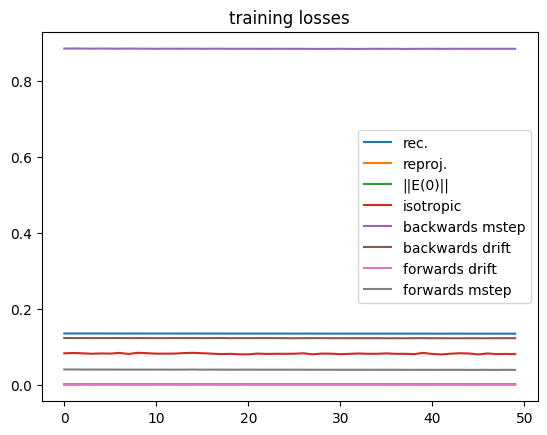

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function uniform_ at 0x7f2701213100>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function uniform_ at 0x7f2701213100>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function zeros_ at 0x7f27012134c0>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2

  1%|          | 1/100 [00:14<24:00, 14.55s/it]

ep 0: train 0.6791990995407104    test 6.755884170532227
rec 0.3599286377429962    mstep 0.31927013397216797    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:27<22:20, 13.68s/it]

1.3894804
it: 2; avg reward: 1444.3177851985934; completion rate: 0.11; gamma_max: 1.3894803524017334
horizon is now 3


  3%|▎         | 3/100 [00:46<26:18, 16.28s/it]

horizon is now 4


  4%|▍         | 4/100 [01:05<27:28, 17.17s/it]

2.0984952
it: 4; avg reward: 1574.0200434179703; completion rate: 0.27; gamma_max: 2.0984952449798584
horizon is now 5


  5%|▌         | 5/100 [01:31<31:59, 20.20s/it]

horizon is now 6


  6%|▌         | 6/100 [01:54<33:35, 21.44s/it]

1.1279225
it: 6; avg reward: 974.0391835653816; completion rate: 0.53; gamma_max: 1.127922534942627
horizon is now 7


  7%|▋         | 7/100 [02:27<38:49, 25.05s/it]

horizon is now 8


100%|██████████| 100/100 [48:02<00:00, 28.83s/it]

ep 99: train 1.2598565816879272    test 1.2526428699493408
rec 0.21476228535175323    mstep 1.0450944900512695    jac 0.0


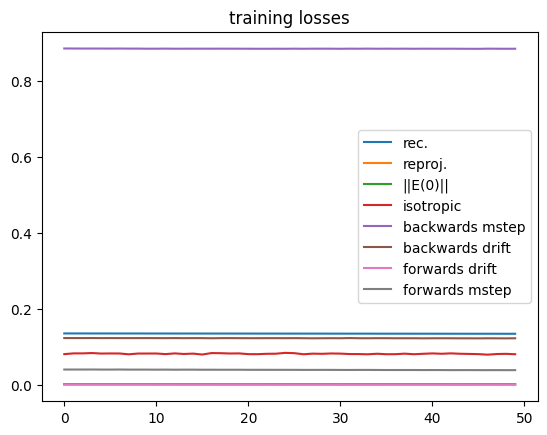

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function uniform_ at 0x7f2701213100>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function uniform_ at 0x7f2701213100>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function zeros_ at 0x7f27012134c0>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2

  1%|          | 1/100 [00:14<24:02, 14.57s/it]

ep 0: train 0.5677887797355652    test 8.084861755371094
rec 0.38204169273376465    mstep 0.18574826419353485    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:27<22:20, 13.68s/it]

2.4722612
it: 2; avg reward: 982.0781082747136; completion rate: 0.36; gamma_max: 2.4722611904144287
horizon is now 3


  3%|▎         | 3/100 [00:48<27:11, 16.82s/it]

horizon is now 4


  4%|▍         | 4/100 [01:06<27:58, 17.49s/it]

2.3328946
it: 4; avg reward: 1219.6882005891594; completion rate: 0.66; gamma_max: 2.3328945636749268
horizon is now 5


  5%|▌         | 5/100 [01:34<33:22, 21.08s/it]

horizon is now 6


  6%|▌         | 6/100 [01:58<34:33, 22.05s/it]

1.4191544
it: 6; avg reward: 1469.3511624090474; completion rate: 0.75; gamma_max: 1.419154405593872
horizon is now 7


  7%|▋         | 7/100 [02:31<39:55, 25.76s/it]

horizon is now 8


  8%|▊         | 8/100 [03:00<41:09, 26.84s/it]

1.392222
it: 8; avg reward: 1541.3020276542152; completion rate: 0.87; gamma_max: 1.3922220468521118
horizon is now 9


  9%|▉         | 9/100 [03:40<46:47, 30.85s/it]

horizon is now 10


 10%|█         | 10/100 [04:14<47:59, 32.00s/it]

1.0117729
it: 10; avg reward: 1377.6688921775713; completion rate: 0.81; gamma_max: 1.011772871017456
horizon is now 11


 11%|█         | 11/100 [04:59<53:07, 35.82s/it]

horizon is now 12


 12%|█▏        | 12/100 [05:39<54:28, 37.14s/it]

0.86886036
it: 12; avg reward: 2072.75188816444; completion rate: 0.93; gamma_max: 0.8688603639602661
horizon is now 13


 13%|█▎        | 13/100 [06:30<59:44, 41.20s/it]

horizon is now 14


 14%|█▍        | 14/100 [07:15<1:00:47, 42.42s/it]

0.9170912
it: 14; avg reward: 1665.188498992409; completion rate: 0.94; gamma_max: 0.9170911908149719
horizon is now 15


 16%|█▌        | 16/100 [08:59<1:05:44, 46.96s/it]

0.65741396
it: 16; avg reward: 2272.5002123282584; completion rate: 0.96; gamma_max: 0.6574139595031738


 18%|█▊        | 18/100 [10:43<1:07:10, 49.16s/it]

0.8082619
it: 18; avg reward: 1652.9785299854834; completion rate: 0.97; gamma_max: 0.8082618713378906


 20%|██        | 20/100 [12:27<1:07:04, 50.31s/it]

0.6178876
it: 20; avg reward: 1748.9387865880344; completion rate: 0.96; gamma_max: 0.6178876161575317


 22%|██▏       | 22/100 [14:11<1:06:02, 50.80s/it]

0.56313956
it: 22; avg reward: 1759.024981319538; completion rate: 0.91; gamma_max: 0.5631395578384399


 24%|██▍       | 24/100 [15:55<1:04:38, 51.03s/it]

0.4788585
it: 24; avg reward: 1827.3021662098536; completion rate: 0.9; gamma_max: 0.47885850071907043


 26%|██▌       | 26/100 [17:38<1:02:59, 51.08s/it]

0.5649295
it: 26; avg reward: 1483.1673413691813; completion rate: 0.87; gamma_max: 0.5649294853210449


 28%|██▊       | 28/100 [19:22<1:01:21, 51.13s/it]

0.48867503
it: 28; avg reward: 1774.1561681998223; completion rate: 0.9; gamma_max: 0.4886750280857086


 30%|███       | 30/100 [21:06<59:39, 51.14s/it]  

0.5346888
it: 30; avg reward: 1663.95493530802; completion rate: 0.95; gamma_max: 0.5346887707710266


 32%|███▏      | 32/100 [22:50<57:59, 51.18s/it]  

0.50867
it: 32; avg reward: 2003.831931149575; completion rate: 0.92; gamma_max: 0.5086699724197388


 34%|███▍      | 34/100 [24:34<56:27, 51.33s/it]

0.47017577
it: 34; avg reward: 1714.0377508364272; completion rate: 0.87; gamma_max: 0.47017577290534973


 36%|███▌      | 36/100 [26:18<54:38, 51.22s/it]

0.50676763
it: 36; avg reward: 1341.243210819987; completion rate: 0.82; gamma_max: 0.5067676305770874


 38%|███▊      | 38/100 [28:01<52:44, 51.04s/it]

0.49390686
it: 38; avg reward: 1481.1719338076286; completion rate: 0.88; gamma_max: 0.4939068555831909


 40%|████      | 40/100 [29:45<51:08, 51.15s/it]

0.5622409
it: 40; avg reward: 2088.2360269702413; completion rate: 0.85; gamma_max: 0.5622408986091614


 42%|████▏     | 42/100 [31:28<49:23, 51.09s/it]

0.45123762
it: 42; avg reward: 1605.6357131485454; completion rate: 0.84; gamma_max: 0.45123761892318726


 44%|████▍     | 44/100 [33:11<47:35, 51.00s/it]

0.5253983
it: 44; avg reward: 1693.0254666112485; completion rate: 0.83; gamma_max: 0.525398313999176


 46%|████▌     | 46/100 [34:55<46:00, 51.12s/it]

0.42031634
it: 46; avg reward: 1938.9628711608668; completion rate: 0.86; gamma_max: 0.42031633853912354


 48%|████▊     | 48/100 [36:38<44:15, 51.06s/it]

0.35824776
it: 48; avg reward: 1144.096238618366; completion rate: 0.9; gamma_max: 0.3582477569580078


 50%|█████     | 50/100 [38:22<42:34, 51.09s/it]

0.40642485
it: 50; avg reward: 1495.9654685770402; completion rate: 0.86; gamma_max: 0.4064248502254486


 52%|█████▏    | 52/100 [40:05<40:51, 51.08s/it]

0.42243907
it: 52; avg reward: 1569.7521946117283; completion rate: 0.86; gamma_max: 0.4224390685558319


 54%|█████▍    | 54/100 [41:49<39:16, 51.22s/it]

0.43402922
it: 54; avg reward: 2171.211829350006; completion rate: 0.76; gamma_max: 0.434029221534729


 56%|█████▌    | 56/100 [43:32<37:25, 51.04s/it]

0.39042306
it: 56; avg reward: 1316.854729471654; completion rate: 0.81; gamma_max: 0.390423059463501


 58%|█████▊    | 58/100 [45:15<35:39, 50.95s/it]

0.38894016
it: 58; avg reward: 1783.0691800351653; completion rate: 0.86; gamma_max: 0.38894015550613403


 60%|██████    | 60/100 [46:59<34:08, 51.21s/it]

0.33462882
it: 60; avg reward: 1652.0118296804349; completion rate: 0.88; gamma_max: 0.3346288204193115


 62%|██████▏   | 62/100 [48:43<32:24, 51.17s/it]

0.34069452
it: 62; avg reward: 1357.7824354801094; completion rate: 0.87; gamma_max: 0.34069451689720154


 64%|██████▍   | 64/100 [50:27<30:41, 51.14s/it]

0.3728929
it: 64; avg reward: 2080.222143445421; completion rate: 0.85; gamma_max: 0.3728928864002228


 66%|██████▌   | 66/100 [52:10<28:56, 51.08s/it]

0.3729054
it: 66; avg reward: 1557.5369712048248; completion rate: 0.87; gamma_max: 0.3729054033756256


 68%|██████▊   | 68/100 [53:54<27:14, 51.08s/it]

0.3288069
it: 68; avg reward: 1509.1126294137305; completion rate: 0.8; gamma_max: 0.32880690693855286


 70%|███████   | 70/100 [55:38<25:35, 51.19s/it]

0.36553392
it: 70; avg reward: 2284.8201994097367; completion rate: 0.84; gamma_max: 0.3655339181423187


 72%|███████▏  | 72/100 [57:21<23:51, 51.11s/it]

0.3393249
it: 72; avg reward: 1986.8125313966132; completion rate: 0.91; gamma_max: 0.3393248915672302


 74%|███████▍  | 74/100 [59:05<22:09, 51.15s/it]

0.3931196
it: 74; avg reward: 2324.0505883233236; completion rate: 0.84; gamma_max: 0.39311960339546204


 76%|███████▌  | 76/100 [1:00:48<20:25, 51.08s/it]

0.35159314
it: 76; avg reward: 1725.1281108251544; completion rate: 0.87; gamma_max: 0.35159313678741455


 78%|███████▊  | 78/100 [1:02:32<18:43, 51.06s/it]

0.3593791
it: 78; avg reward: 1700.1936170713655; completion rate: 0.82; gamma_max: 0.3593791127204895


 80%|████████  | 80/100 [1:04:16<17:05, 51.29s/it]

0.2913821
it: 80; avg reward: 1500.2531805811534; completion rate: 0.82; gamma_max: 0.2913821041584015


 82%|████████▏ | 82/100 [1:06:00<15:20, 51.16s/it]

0.36210054
it: 82; avg reward: 1586.5382393204732; completion rate: 0.88; gamma_max: 0.3621005415916443


 84%|████████▍ | 84/100 [1:07:43<13:38, 51.18s/it]

0.3687158
it: 84; avg reward: 2211.958478998698; completion rate: 0.83; gamma_max: 0.3687157928943634


 86%|████████▌ | 86/100 [1:09:27<11:56, 51.15s/it]

0.3676732
it: 86; avg reward: 1636.9027040693072; completion rate: 0.88; gamma_max: 0.36767318844795227


 88%|████████▊ | 88/100 [1:11:11<10:14, 51.20s/it]

0.340699
it: 88; avg reward: 1778.0269542869955; completion rate: 0.93; gamma_max: 0.3406989872455597


 90%|█████████ | 90/100 [1:12:56<08:34, 51.48s/it]

0.32203415
it: 90; avg reward: 1646.6023170662381; completion rate: 0.82; gamma_max: 0.32203415036201477


 92%|█████████▏| 92/100 [1:14:39<06:50, 51.29s/it]

0.4237741
it: 92; avg reward: 1897.7825893154422; completion rate: 0.89; gamma_max: 0.4237740933895111


 94%|█████████▍| 94/100 [1:16:23<05:07, 51.28s/it]

0.3771464
it: 94; avg reward: 1935.7303545125556; completion rate: 0.85; gamma_max: 0.3771463930606842


 96%|█████████▌| 96/100 [1:18:07<03:24, 51.18s/it]

0.36136943
it: 96; avg reward: 1701.0163138393548; completion rate: 0.91; gamma_max: 0.36136943101882935


 98%|█████████▊| 98/100 [1:19:50<01:42, 51.23s/it]

0.41200832
it: 98; avg reward: 1844.7568574553331; completion rate: 0.84; gamma_max: 0.4120083153247833


100%|██████████| 100/100 [1:21:53<00:00, 49.13s/it]

ep 99: train 0.5684147477149963    test 0.5762711763381958
rec 0.13683731853961945    mstep 0.43157726526260376    jac 0.0


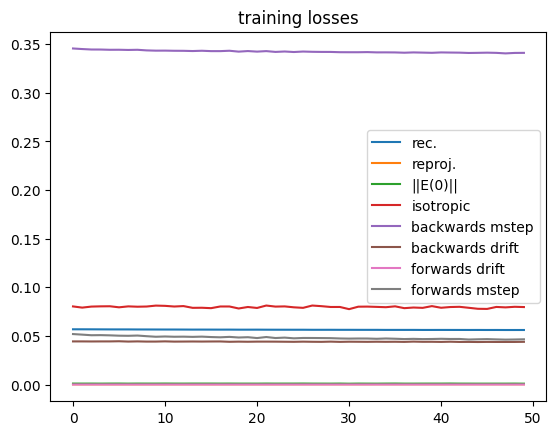

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function uniform_ at 0x7f2701213100>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function uniform_ at 0x7f2701213100>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2701213740>
g bias init is <function zeros_ at 0x7f27012134c0>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f2

  1%|          | 1/100 [00:14<24:05, 14.60s/it]

ep 0: train 0.4397883415222168    test 7.558098793029785
rec 0.292979896068573    mstep 0.14680883288383484    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:27<22:22, 13.70s/it]

1.77341
it: 2; avg reward: 2151.392274567745; completion rate: 0.28; gamma_max: 1.7734099626541138
horizon is now 3


  3%|▎         | 3/100 [00:47<26:54, 16.64s/it]

horizon is now 4


  4%|▍         | 4/100 [01:06<27:43, 17.32s/it]

0.79666364
it: 4; avg reward: 1670.915834222799; completion rate: 0.75; gamma_max: 0.7966636419296265
horizon is now 5


  5%|▌         | 5/100 [01:34<33:31, 21.17s/it]

horizon is now 6


  6%|▌         | 6/100 [01:58<34:37, 22.10s/it]

0.89419246
it: 6; avg reward: 1473.4219094267817; completion rate: 0.71; gamma_max: 0.8941924571990967
horizon is now 7


  7%|▋         | 7/100 [02:31<39:49, 25.69s/it]

horizon is now 8


  8%|▊         | 8/100 [03:00<41:02, 26.76s/it]

1.0213035
it: 8; avg reward: 1711.5887888172103; completion rate: 0.76; gamma_max: 1.0213035345077515
horizon is now 9


  9%|▉         | 9/100 [03:39<46:26, 30.63s/it]

horizon is now 10


 10%|█         | 10/100 [04:13<47:43, 31.81s/it]

0.9566065
it: 10; avg reward: 1398.7504200557682; completion rate: 0.83; gamma_max: 0.9566065073013306
horizon is now 11


 11%|█         | 11/100 [04:58<53:00, 35.73s/it]

horizon is now 12


 12%|█▏        | 12/100 [05:38<54:23, 37.08s/it]

0.8605726
it: 12; avg reward: 1409.8946009347046; completion rate: 0.83; gamma_max: 0.8605725765228271
horizon is now 13


 13%|█▎        | 13/100 [06:28<59:23, 40.96s/it]

horizon is now 14


 14%|█▍        | 14/100 [07:13<1:00:32, 42.24s/it]

0.8952938
it: 14; avg reward: 1760.2667247001573; completion rate: 0.92; gamma_max: 0.8952937722206116
horizon is now 15


 16%|█▌        | 16/100 [08:57<1:05:35, 46.85s/it]

0.78965497
it: 16; avg reward: 1571.6121517710762; completion rate: 0.9; gamma_max: 0.7896549701690674


 18%|█▊        | 18/100 [10:41<1:07:10, 49.15s/it]

0.87954795
it: 18; avg reward: 2000.4510890042413; completion rate: 0.92; gamma_max: 0.8795479536056519


 20%|██        | 20/100 [12:25<1:07:03, 50.29s/it]

0.84737855
it: 20; avg reward: 1646.5215498130601; completion rate: 0.94; gamma_max: 0.8473785519599915


 22%|██▏       | 22/100 [14:10<1:06:05, 50.84s/it]

0.7730744
it: 22; avg reward: 1795.6180069582274; completion rate: 0.91; gamma_max: 0.7730743885040283


 24%|██▍       | 24/100 [15:54<1:04:46, 51.14s/it]

0.765948
it: 24; avg reward: 1855.5816508195517; completion rate: 0.91; gamma_max: 0.7659479975700378


 26%|██▌       | 26/100 [17:38<1:03:06, 51.17s/it]

0.7401943
it: 26; avg reward: 1969.3404199392824; completion rate: 0.92; gamma_max: 0.7401943206787109


 28%|██▊       | 28/100 [19:21<1:01:25, 51.19s/it]

0.61048084
it: 28; avg reward: 1408.9376889563455; completion rate: 0.94; gamma_max: 0.6104808449745178


 30%|███       | 30/100 [21:06<59:52, 51.32s/it]  

0.67684704
it: 30; avg reward: 1689.1853189725384; completion rate: 0.92; gamma_max: 0.6768470406532288


 32%|███▏      | 32/100 [22:50<58:08, 51.31s/it]  

0.64876896
it: 32; avg reward: 2121.2198439333492; completion rate: 0.94; gamma_max: 0.648768961429596


 34%|███▍      | 34/100 [24:34<56:33, 51.42s/it]

0.59525245
it: 34; avg reward: 1913.4969246595017; completion rate: 0.95; gamma_max: 0.5952524542808533


 36%|███▌      | 36/100 [26:18<54:49, 51.39s/it]

0.55207896
it: 36; avg reward: 1961.1625950240557; completion rate: 0.94; gamma_max: 0.5520789623260498


 38%|███▊      | 38/100 [28:02<53:04, 51.36s/it]

0.46991822
it: 38; avg reward: 1476.8478218791263; completion rate: 0.92; gamma_max: 0.46991822123527527


 40%|████      | 40/100 [29:47<51:27, 51.45s/it]

0.51107633
it: 40; avg reward: 1827.9018858521622; completion rate: 0.95; gamma_max: 0.5110763311386108


 42%|████▏     | 42/100 [31:31<49:39, 51.36s/it]

0.4299467
it: 42; avg reward: 1766.150652922739; completion rate: 0.92; gamma_max: 0.4299466907978058


 44%|████▍     | 44/100 [33:15<47:52, 51.29s/it]

0.5481006
it: 44; avg reward: 2057.4455082549102; completion rate: 0.95; gamma_max: 0.5481005907058716


 46%|████▌     | 46/100 [34:59<46:19, 51.47s/it]

0.48951918
it: 46; avg reward: 2410.6419521156995; completion rate: 0.96; gamma_max: 0.4895191788673401


 48%|████▊     | 48/100 [36:44<44:35, 51.45s/it]

0.3463986
it: 48; avg reward: 2243.416089775588; completion rate: 0.86; gamma_max: 0.34639859199523926


 50%|█████     | 50/100 [38:27<42:46, 51.33s/it]

0.4555395
it: 50; avg reward: 2004.1547284708292; completion rate: 0.88; gamma_max: 0.4555394947528839


 52%|█████▏    | 52/100 [40:11<40:59, 51.25s/it]

0.44675416
it: 52; avg reward: 2079.8846659422748; completion rate: 0.91; gamma_max: 0.4467541575431824


 54%|█████▍    | 54/100 [41:56<39:25, 51.43s/it]

0.46877304
it: 54; avg reward: 2015.5510596485842; completion rate: 0.93; gamma_max: 0.4687730371952057


 56%|█████▌    | 56/100 [43:40<37:41, 51.39s/it]

0.37543553
it: 56; avg reward: 1805.6624386066883; completion rate: 0.89; gamma_max: 0.3754355311393738


 58%|█████▊    | 58/100 [45:24<35:55, 51.32s/it]

0.44073737
it: 58; avg reward: 1893.2078123871383; completion rate: 0.94; gamma_max: 0.44073736667633057


 60%|██████    | 60/100 [47:08<34:13, 51.33s/it]

0.3973961
it: 60; avg reward: 2033.2086425154869; completion rate: 0.91; gamma_max: 0.3973960876464844


 62%|██████▏   | 62/100 [48:52<32:36, 51.49s/it]

0.4240595
it: 62; avg reward: 2625.0260777135704; completion rate: 0.94; gamma_max: 0.42405951023101807


 64%|██████▍   | 64/100 [50:36<30:50, 51.41s/it]

0.44732696
it: 64; avg reward: 2889.7136650022203; completion rate: 0.93; gamma_max: 0.4473269581794739


 66%|██████▌   | 66/100 [52:20<29:06, 51.38s/it]

0.38352045
it: 66; avg reward: 2254.6365694557217; completion rate: 0.88; gamma_max: 0.3835204541683197


 68%|██████▊   | 68/100 [54:04<27:20, 51.28s/it]

0.37257284
it: 68; avg reward: 2297.319432253035; completion rate: 0.86; gamma_max: 0.3725728392601013


 70%|███████   | 70/100 [55:48<25:36, 51.22s/it]

0.41260707
it: 70; avg reward: 2159.538692899552; completion rate: 0.91; gamma_max: 0.4126070737838745


 72%|███████▏  | 72/100 [57:32<23:59, 51.41s/it]

0.3459692
it: 72; avg reward: 2365.065118186439; completion rate: 0.85; gamma_max: 0.34596920013427734


 74%|███████▍  | 74/100 [59:16<22:14, 51.31s/it]

0.38409814
it: 74; avg reward: 2220.533279717716; completion rate: 0.89; gamma_max: 0.3840981423854828


 76%|███████▌  | 76/100 [1:01:00<20:30, 51.29s/it]

0.38804233
it: 76; avg reward: 1909.60495178526; completion rate: 0.91; gamma_max: 0.3880423307418823


 78%|███████▊  | 78/100 [1:02:44<18:48, 51.28s/it]

0.45849776
it: 78; avg reward: 2721.2660767831644; completion rate: 0.81; gamma_max: 0.4584977626800537


 80%|████████  | 80/100 [1:04:27<17:02, 51.14s/it]

1.3375355
it: 80; avg reward: 3227.42259857845; completion rate: 0.8514851485148515; gamma_max: 1.3375355005264282


 82%|████████▏ | 82/100 [1:06:12<15:24, 51.36s/it]

0.35144025
it: 82; avg reward: 2948.0714902105155; completion rate: 0.84; gamma_max: 0.3514402508735657


 84%|████████▍ | 84/100 [1:07:56<13:40, 51.27s/it]

0.33549103
it: 84; avg reward: 2445.173495683333; completion rate: 0.93; gamma_max: 0.33549103140830994


 86%|████████▌ | 86/100 [1:09:40<11:57, 51.28s/it]

0.40983364
it: 86; avg reward: 2592.668709028253; completion rate: 0.79; gamma_max: 0.4098336398601532


 88%|████████▊ | 88/100 [1:11:23<10:13, 51.14s/it]

0.40807378
it: 88; avg reward: 2553.679136656897; completion rate: 0.9; gamma_max: 0.4080737829208374


 90%|█████████ | 90/100 [1:13:07<08:31, 51.18s/it]

0.41122916
it: 90; avg reward: 2778.3169203317543; completion rate: 0.82; gamma_max: 0.4112291634082794


 92%|█████████▏| 92/100 [1:14:51<06:51, 51.41s/it]

0.2609974
it: 92; avg reward: 1898.0507534358505; completion rate: 0.81; gamma_max: 0.2609974145889282


 94%|█████████▍| 94/100 [1:16:35<05:07, 51.23s/it]

0.39327416
it: 94; avg reward: 2116.626534208392; completion rate: 0.86; gamma_max: 0.3932741582393646


 96%|█████████▌| 96/100 [1:18:18<03:24, 51.16s/it]

0.32952344
it: 96; avg reward: 2392.096841105677; completion rate: 0.89; gamma_max: 0.3295234441757202


 98%|█████████▊| 98/100 [1:20:02<01:42, 51.24s/it]

0.36074546
it: 98; avg reward: 1940.7477291602752; completion rate: 0.85; gamma_max: 0.36074545979499817


100%|██████████| 100/100 [1:22:05<00:00, 49.25s/it]

ep 99: train 0.5696553587913513    test 0.5868509411811829
rec 0.13731686770915985    mstep 0.4323376715183258    jac 0.0


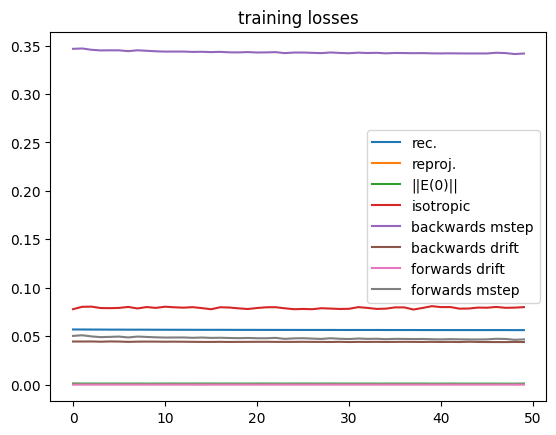

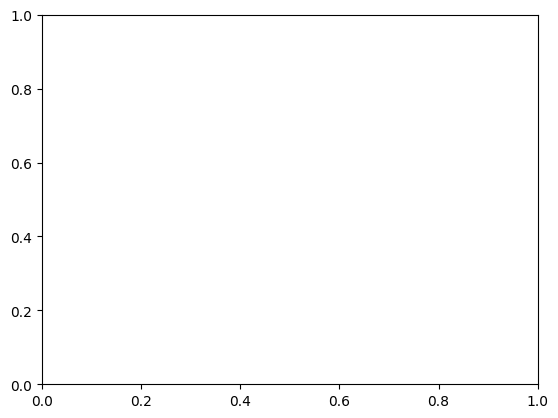

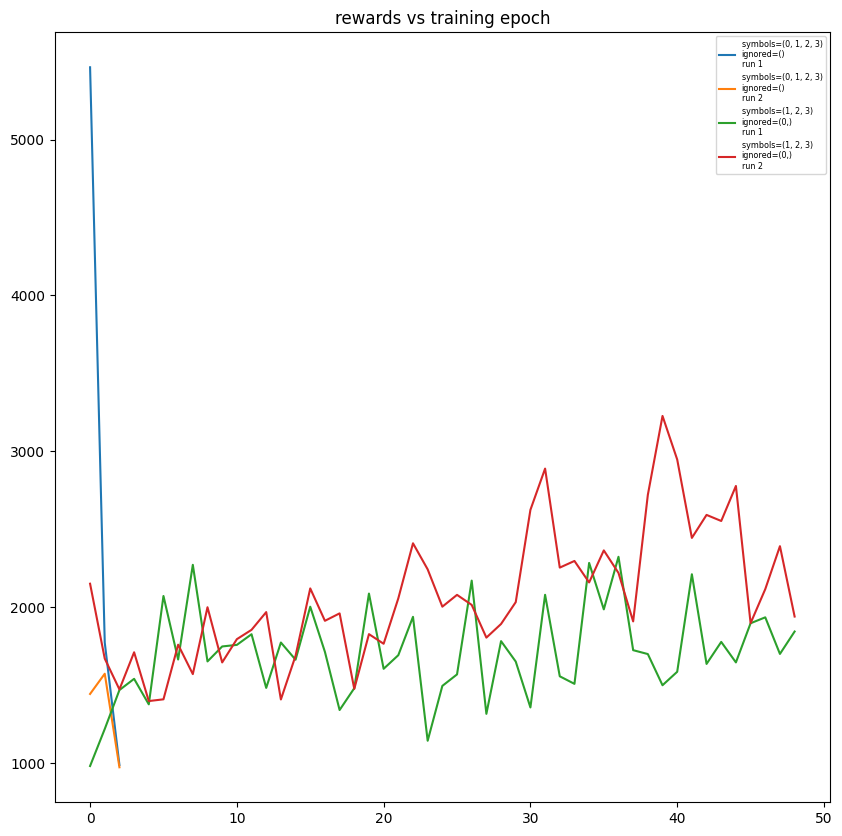

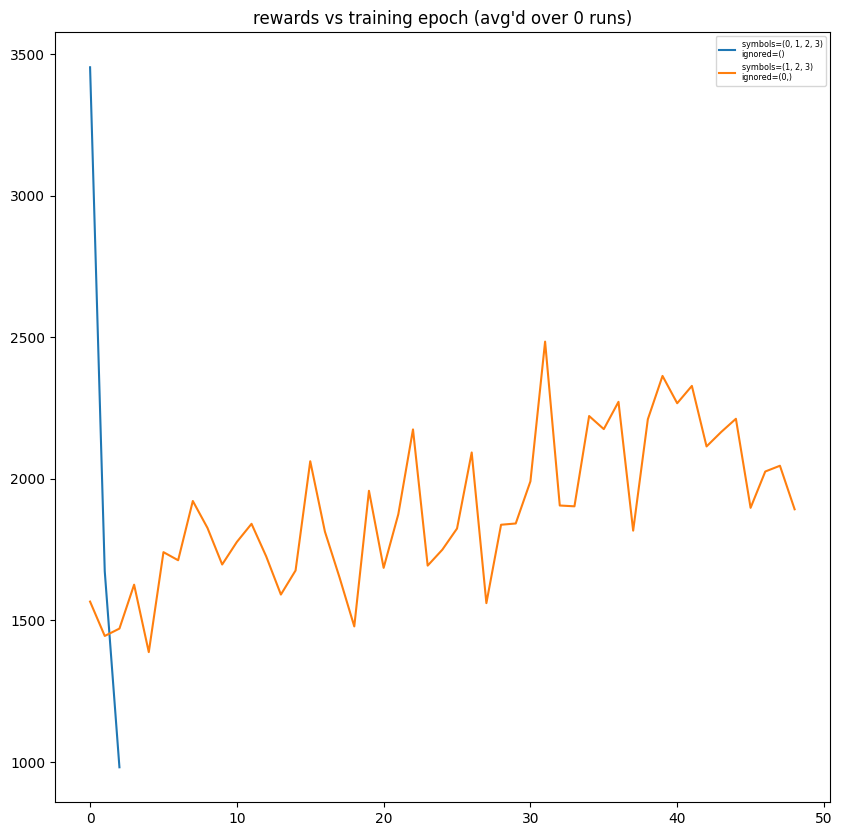

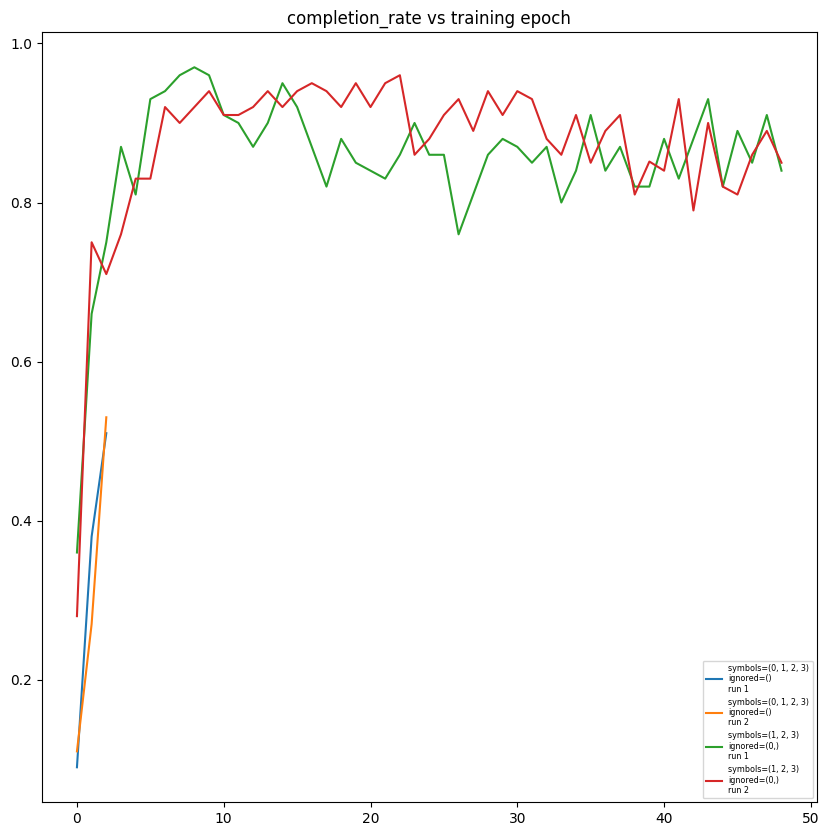

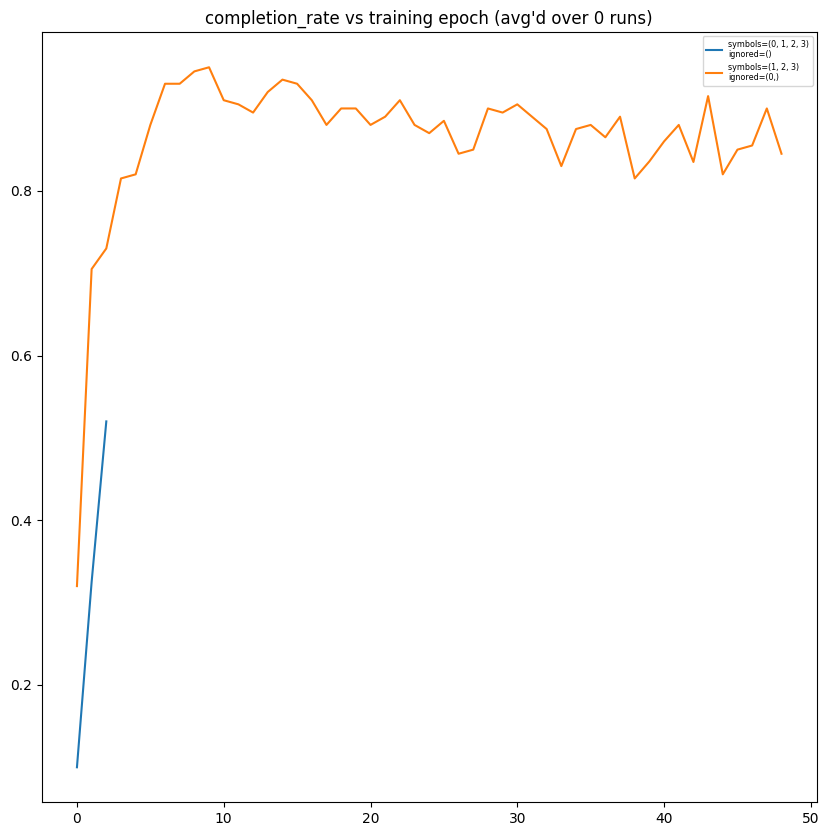

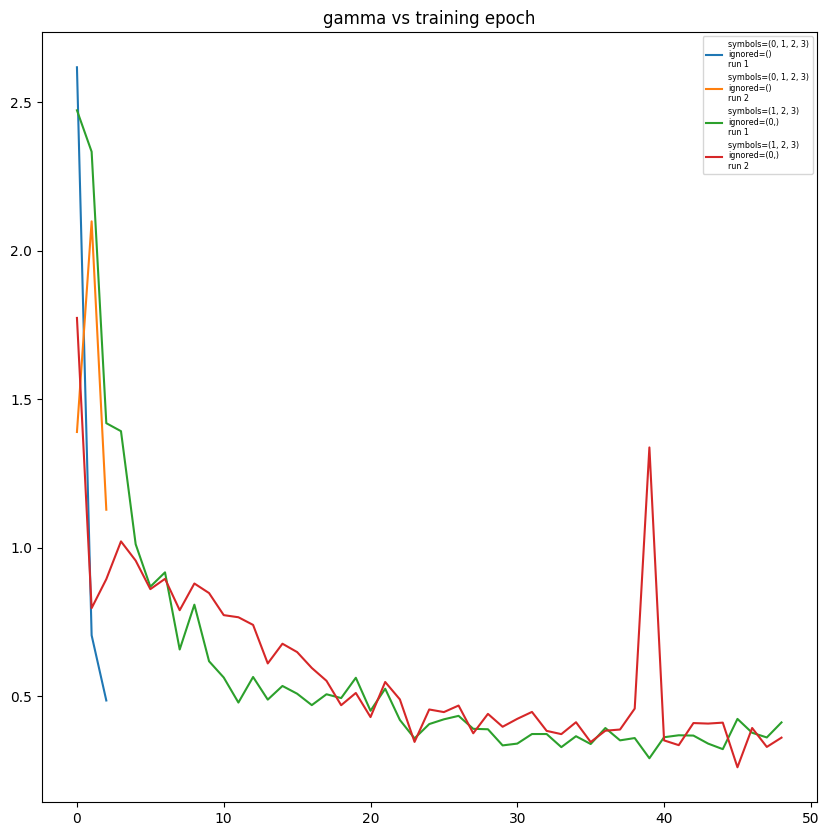

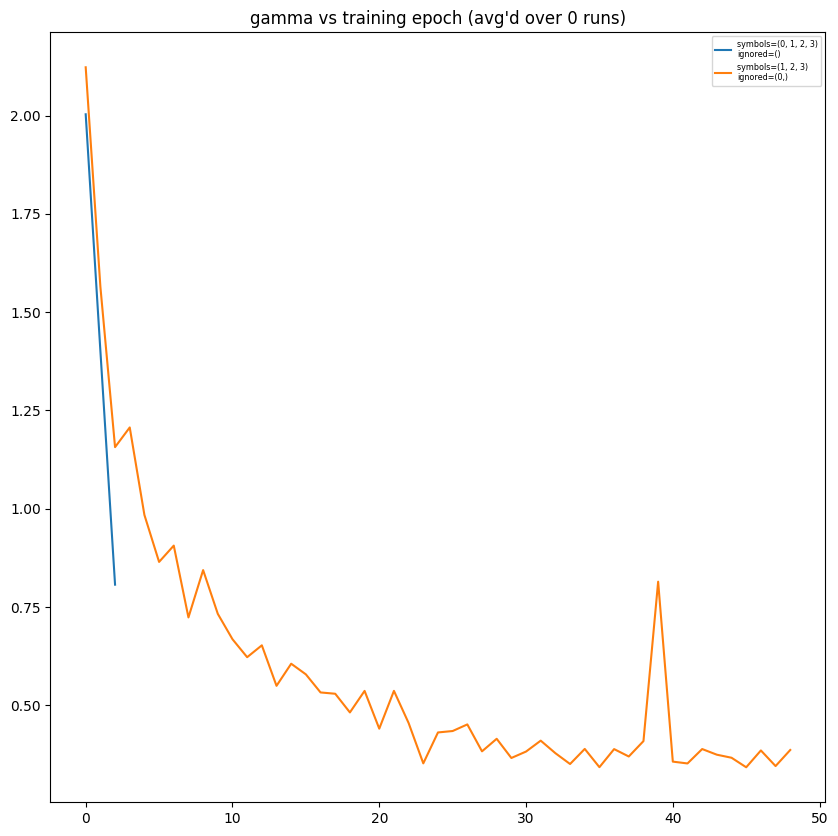

final state
 [(0, 1, 3), (2,)]
saving fwd_penalty_exp_2.pkl
15


In [3]:
from experiments import run_experiment_new
#spec = {'m':[3, 4, 5], 'rec_jac':[True, False, True], 'ptb_eps_x':[1e-9, 1e-6, 1e-3]}

'''
spec = {"predict_mstep" : [True, False, True], 
        "penalize_rec" : [True, True, True], 
        "penalize_reproj" : [False, True, True],
        "penalize_encoder_diagram_mstep" : [False, True, True]}
'''
name = 'fwd_penalty_exp_2'
'''
spec = {'m':[7, 8, 9],
        'm_schedule':[7*[0], 8*[0], 9*[0]]}
'''
spec = {'symbols': [(0,1,2,3), (0, 1, 3), (1, 2, 3), (1, 3)],
        'ignored': [(), (2,), (0,), (0, 2)]}
#n_runs = len(list(spec.items())[0][1])*[1]
n_runs = [2, 0, 2, 0]
print(params.m)
exp=run_experiment_new(data, spec, plot=True, n_runs=n_runs, fname=name, save=True)
print(params.m)


In [22]:
#######################
### Save Experiment ###
#######################

#save_name = 'nontrivial_2'
#save_experiment(save_name, exp)

saving nontrivial_2.pkl


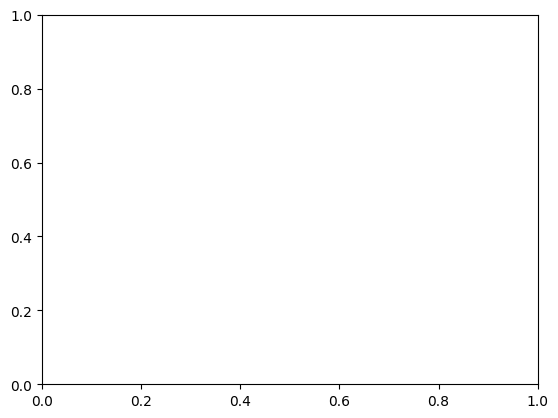

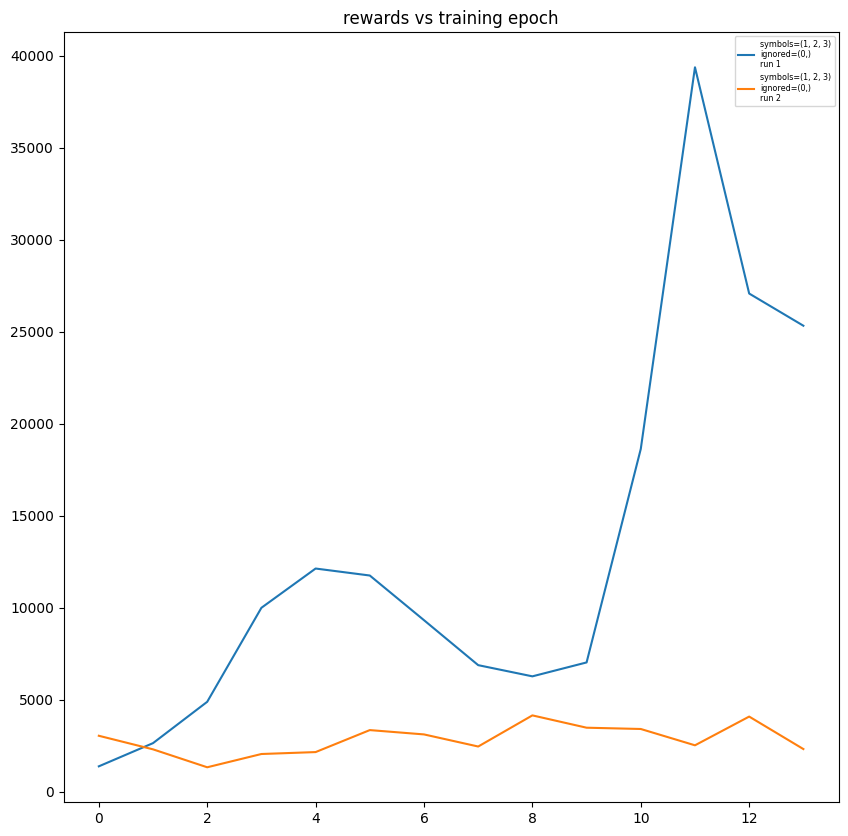

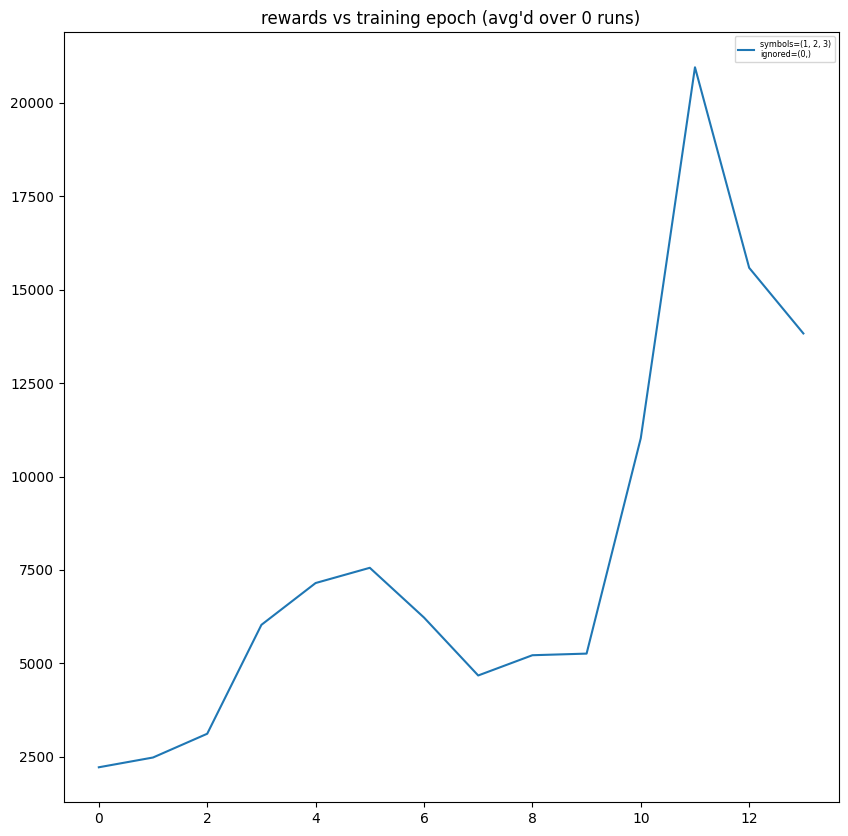

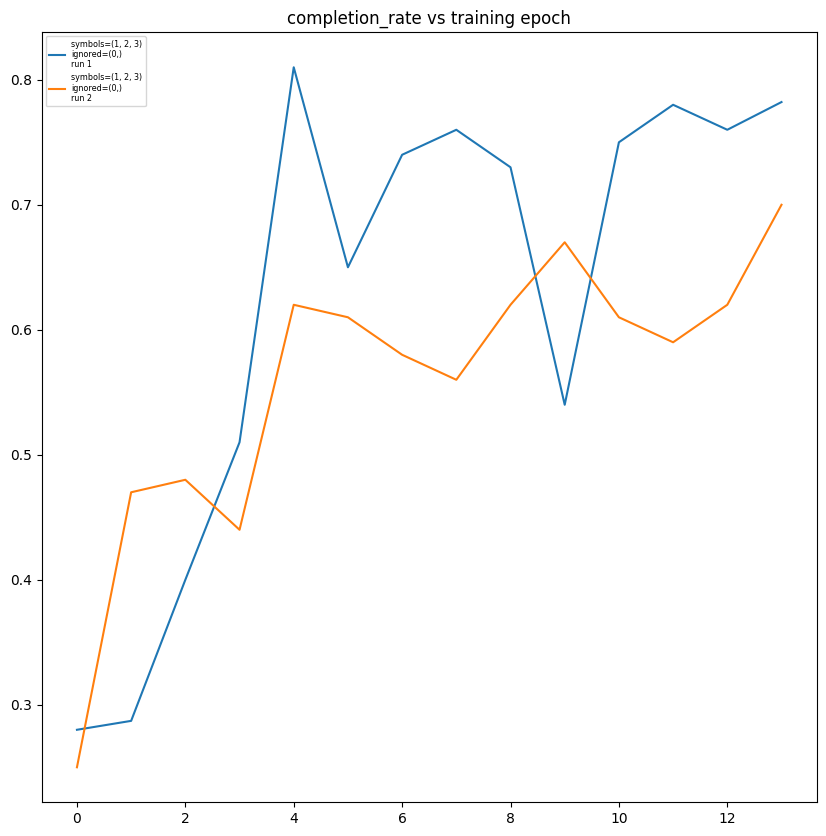

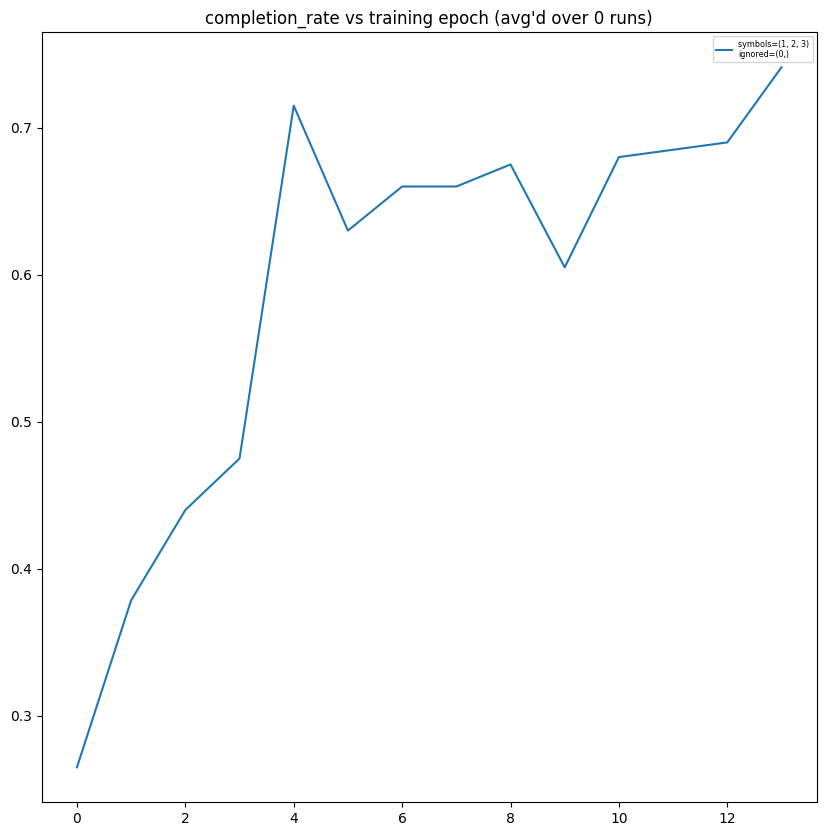

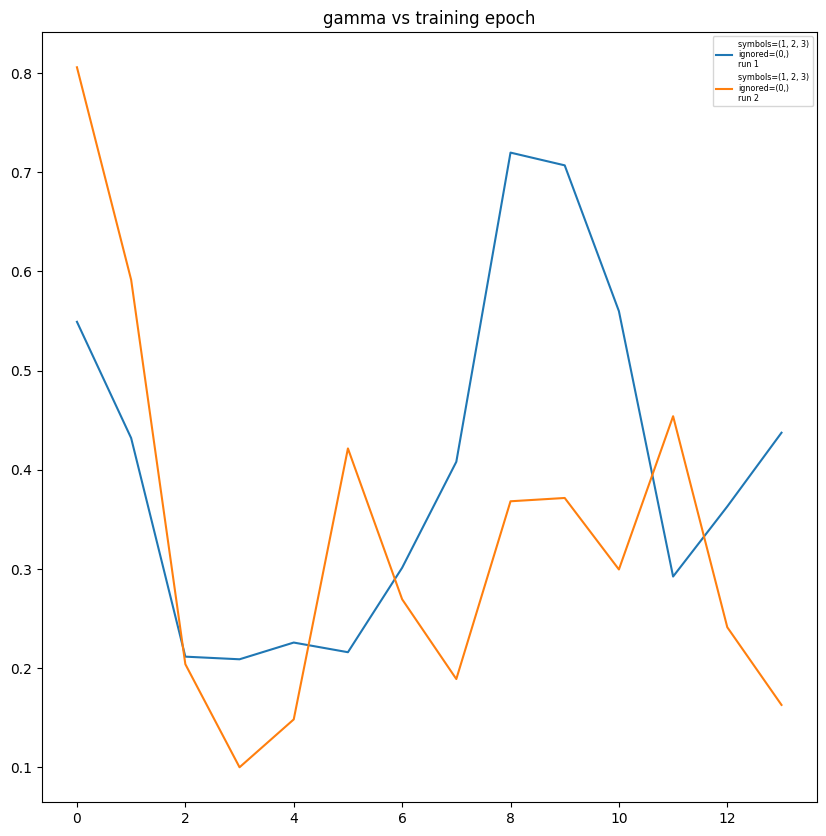

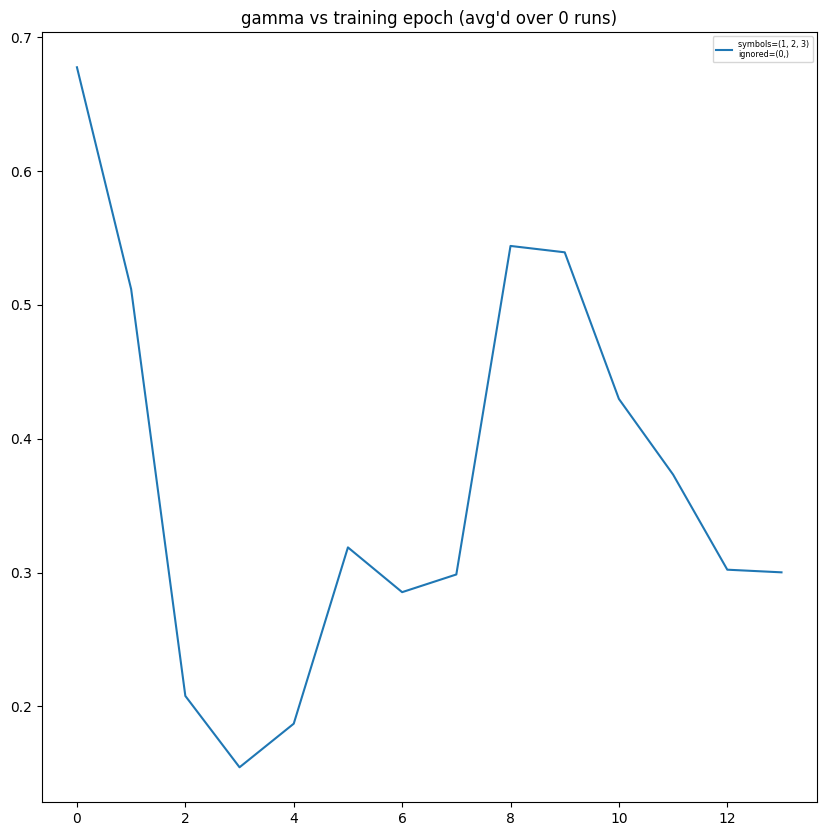

In [3]:
#######################
### Load Experiment ###
#######################

#name = "test_exp"
#name = "backwards-both_runs"
#name = 'both_runs'
#name = "small_pert"
#name = "extra_small_pert"
#name = "xxs_pert_exp"
#name = 'm-ablation'
#name = 'symbol-ablation-default_dataset'
#name = 'symbol-ablation-default_dataset_2'
#name = 'nontrivial_2'
#name = 'fwd_penalty_exp'
name = 'fwd_penalty_exp_2'
exp = load_experiment(name)
plot_experiment_new(exp)

In [4]:
config_idx = 2#2
run_idx = 0#1
best_model_idx = np.argmax(exp['completion_rate'][config_idx][1][run_idx])
#best_model_idx = np.argmin(exp['gamma'][config_idx][1][run_idx])
#best_model_idx = 79 #-2
#best_model_idx = -1
print(best_model_idx)
ae = exp['ae_list'][config_idx][1][run_idx][best_model_idx]
fdyn = exp['fdyn_list'][config_idx][1][run_idx][best_model_idx]
ae.encode(torch.tensor([0.,0.,0.,0.]))

8


tensor([-0.0008,  0.0004], device='cuda:0', grad_fn=<ViewBackward0>)

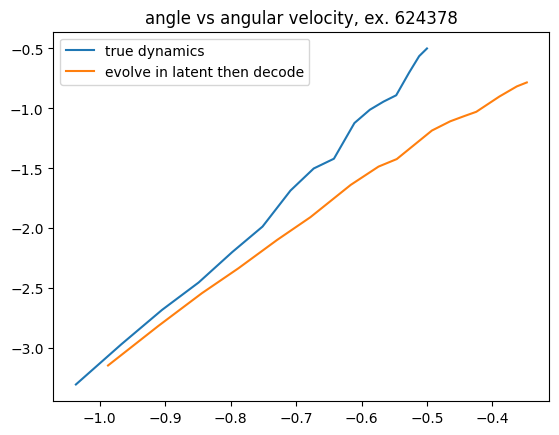

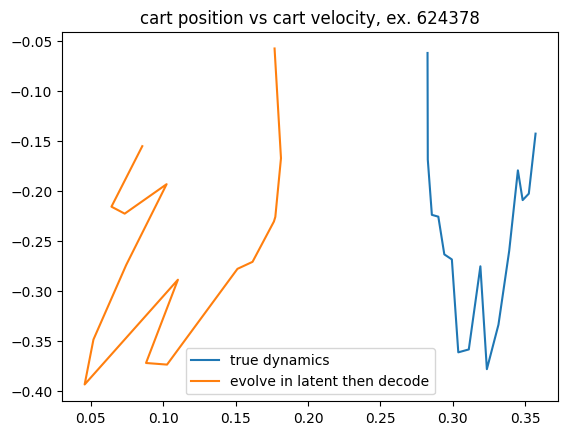

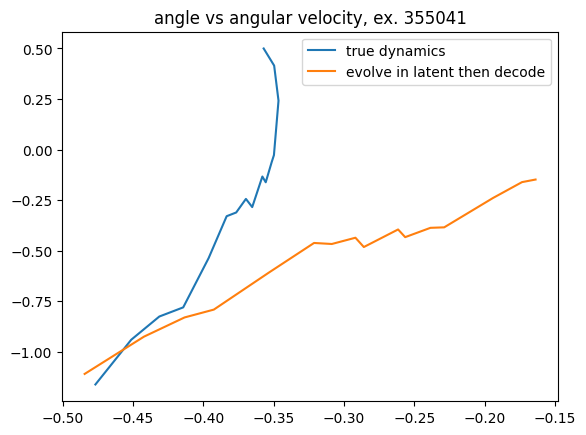

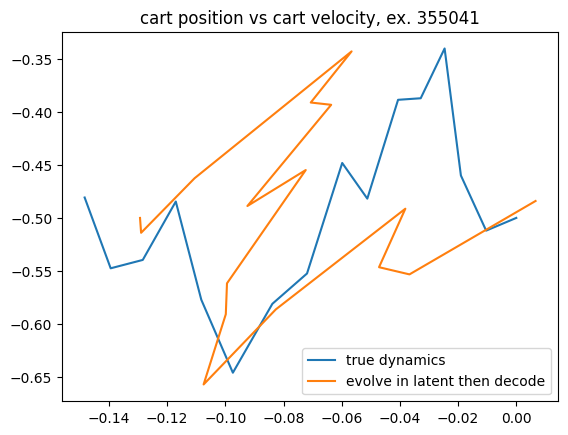

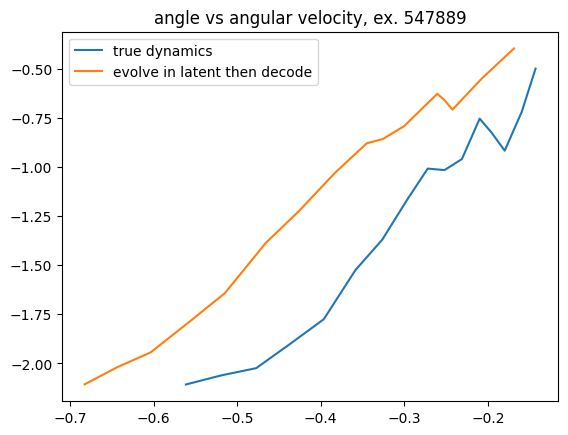

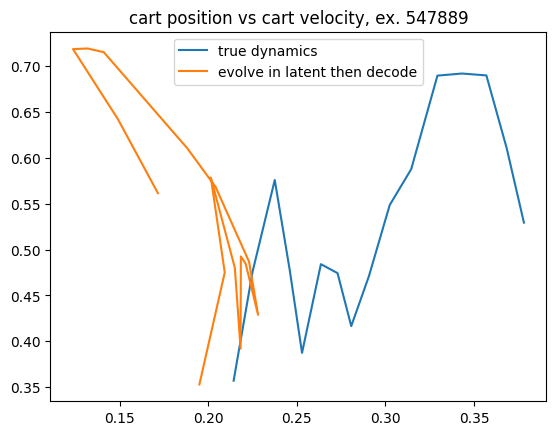

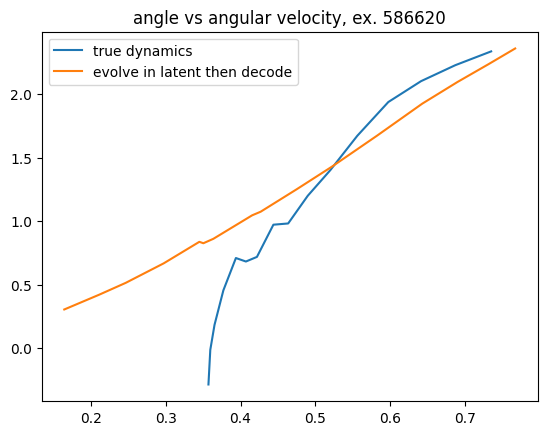

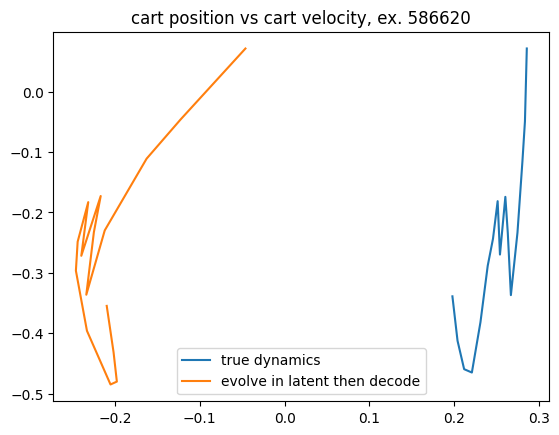

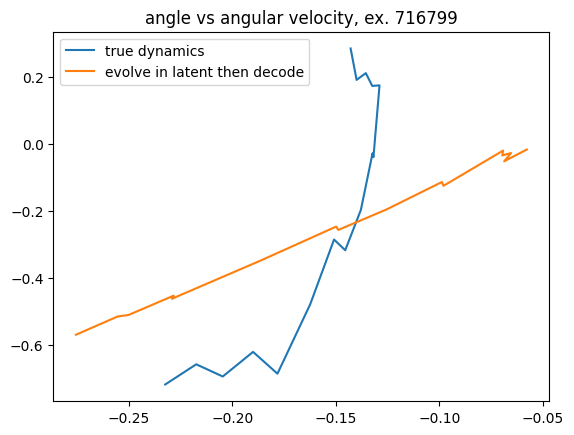

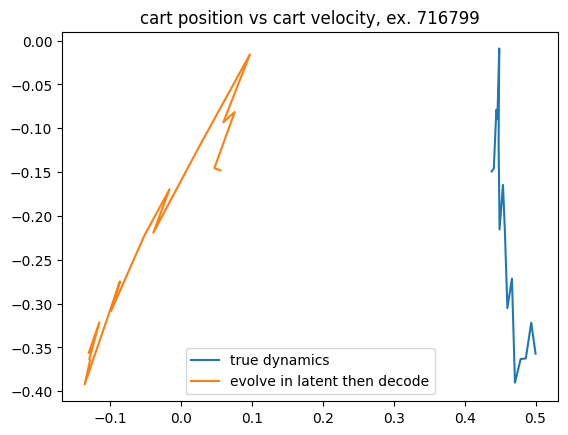

In [5]:
#########################
### Plot Trajectories ###
#########################

plot_trajectories(ae, fdyn, Xtest[0], Utest[0], 5, steps=params.traj_len)#params.m+1)

In [ ]:
######################
### Plot Stability ###
######################

from plotting import plot_stability
n_pts = 5000
eps = np.pi/6 #np.pi/3 
T = 500
tol = np.pi/2
low = [0+-eps, -eps, -eps, -eps]
high = [0+eps, eps, eps, eps]
plot_stability(ae, fdyn, n_pts, low, high, tol, T, visualize=False, latent_traj=True)

In [ ]:
##############################################
### Plot Inverse Image of Latent Norm Ball ###
##############################################

from plotting import plot_preimage_norm_ball

n = 10000
i = 1
j = 2
ivals = [0.]
jvals = [0.]
for ival in ivals:
    for jval in jvals:
        plot_preimage_norm_ball(ae, 0.25, i=i, ival=ival, j=j, jval=jval, n=n) #0.25

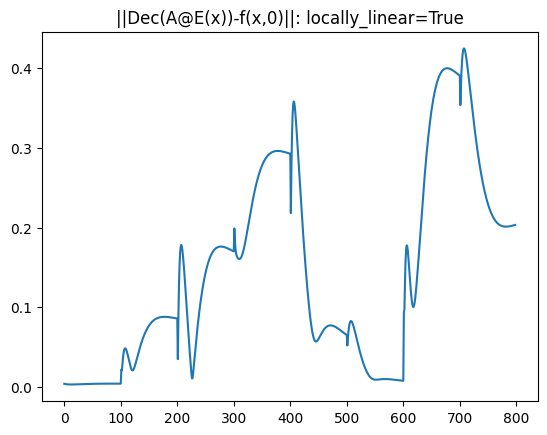

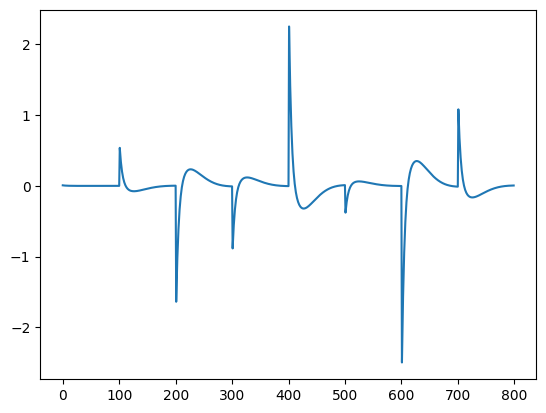

In [6]:
########################
### Stabilize System ###
########################

from controls import LQR

lqr = LQR(ae, fdyn)
stabilize_cartpole(lqr, ae, T=1, tmax=800, stabilize=True)

z_eq tensor([[-0.0008,  0.0004]], device='cuda:0', grad_fn=<AddmmBackward0>)


100%|██████████| 250/250 [00:28<00:00,  8.89it/s]


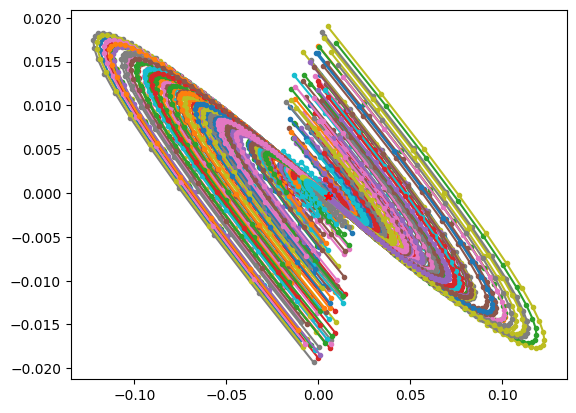

100%|██████████| 250/250 [00:25<00:00,  9.76it/s]


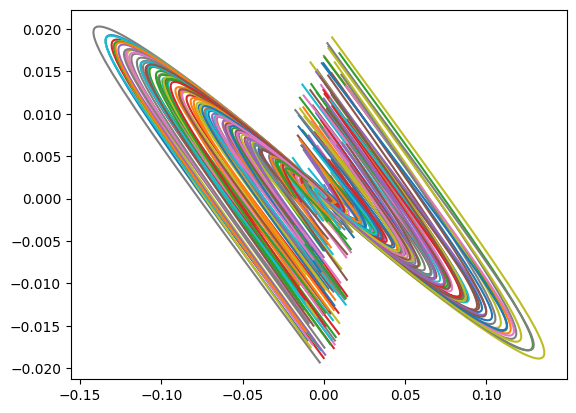

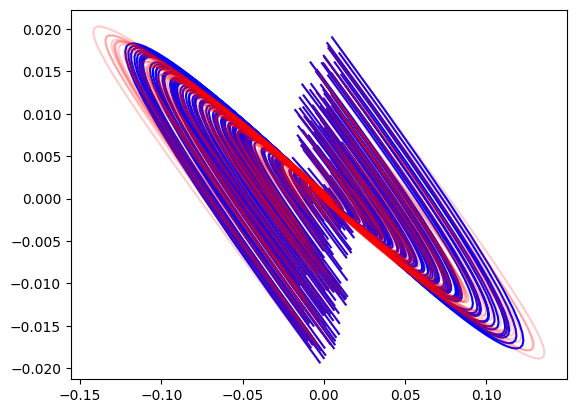

x data (250, 301, 4)
z data (250, 301, 2)
z proj data (250, 301, 2)
u data (250, 300, 1)
gamma forward 0.0006553656
gamma backward 0.05619013


In [7]:
####################################
### Initialize Data for Lyapunov ###
####################################

from plotting import plot_latent_trajectories
from utils import rollout_trajectories

r = 1.2e-1#2e-3 #1e-3
r_test = r #1e-3 #5e-3
rz_init = 0.02 #0.080 #0.005
#rx_init = rz_init
#rz_proj_init = 0.06
n_traj = 250 #3000 #250 350 1000
T = 300
b = ae.encode(torch.tensor(4*[0.,])).cpu().detach().numpy()


for u_cost in [1]:
    lqr = LQR(ae, fdyn, u_cost=u_cost)
    pts, z_data, x_init_cond = plot_latent_trajectories(ae, fdyn, rz_init, n_traj, T=T, plot_quadratic=False, origin_spec=(b, r), lqr=lqr) #r=0.05
    x_data, z_proj_data, u_data, gammas = rollout_trajectories (ae, fdyn, lqr, x_init_cond, plot=True, n_traj=n_traj, T=T)
    gamma_fwd, gamma_bwd = gammas
    
    for zi in z_data:
        plt.plot(zi[:,0], zi[:,1], 'b-')
    for zi in z_proj_data:
        plt.plot(zi[:,0], zi[:,1], 'r-', alpha=0.2)
    plt.show()
    
    u_data = u_data[...,np.newaxis]
    
    #print(pts.shape)
    print("x data", x_data.shape)
    print("z data", z_data.shape)
    print("z proj data", z_proj_data.shape)
    print("u data", u_data.shape)
    print("gamma forward", gamma_fwd)
    print("gamma backward", gamma_bwd)

z_eq: tensor([-0.0008,  0.0004], device='cuda:0', grad_fn=<ViewBackward0>)
pd loss: False
dyn loss: True
lb loss False
grad loss False
rho: 0.9
c lb 0.1
l_dyn 1
l_pd 1
l_lb 1
l_grad 1e-06
using grid data, grid_density: 100
features: 128
coeff: 0.1
LyapunovGeneral(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=False)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=1, bias=False)
  )
)
it 0: tensor([2.2744e-05], device='cuda:0', grad_fn=<AddBackward0>)


/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


it 1000: tensor([3.5703e-08], device='cuda:0', grad_fn=<AddBackward0>)
it 2000: tensor([3.3288e-08], device='cuda:0', grad_fn=<AddBackward0>)
it 3000: tensor([3.2781e-08], device='cuda:0', grad_fn=<AddBackward0>)
it 4000: tensor([3.2675e-08], device='cuda:0', grad_fn=<AddBackward0>)
alpha 0.02239909954369068
torch.Size([75250, 2])
Lipschitz constant tensor(2.2666, device='cuda:0', grad_fn=<MaxBackward1>)


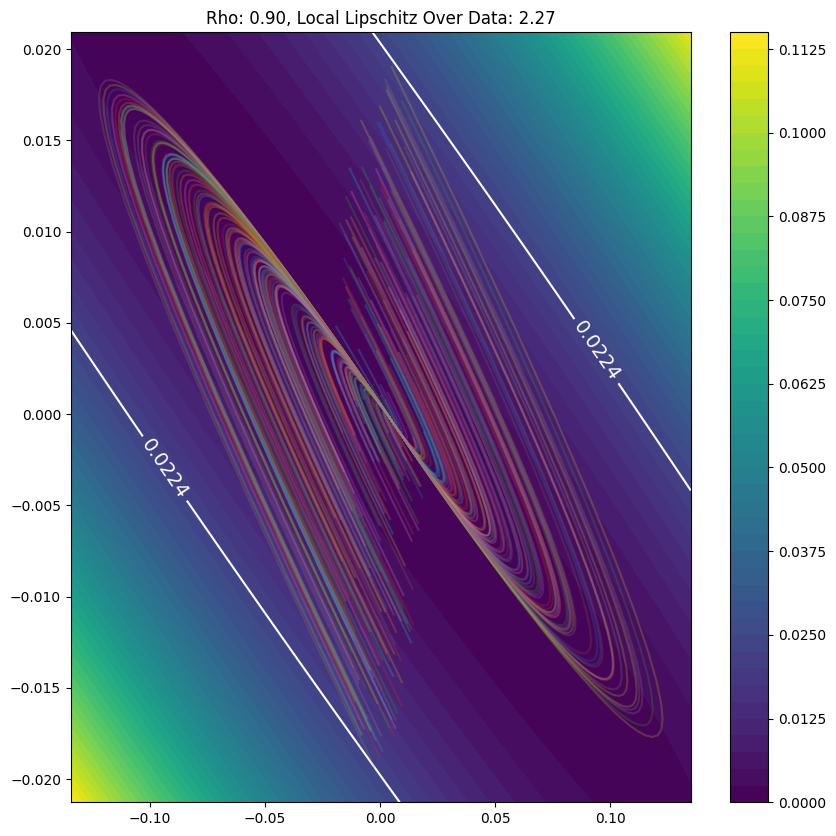

In [8]:
###############################
### Learn Lyapunov Function ###
###############################

from controls import mlp_lyapunov, mlp_lyapunov_reparam
from experiments import load_experiment

z_eq = ae.encode(torch.tensor([0.,0.,0.,0]).float())
#z_eq = torch.tensor([0.,0.]).float()
print("z_eq:", z_eq)
rho = 0.90
V, rho, alpha, lip = mlp_lyapunov_reparam(z_data, epochs=int(0.5e4), lr=2e-4, grid_dens=100, rho=rho, z_eq=z_eq) #ep 3e4

(310, 4)
0.019961053505539894


100%|██████████| 142/142 [00:53<00:00,  2.64it/s]


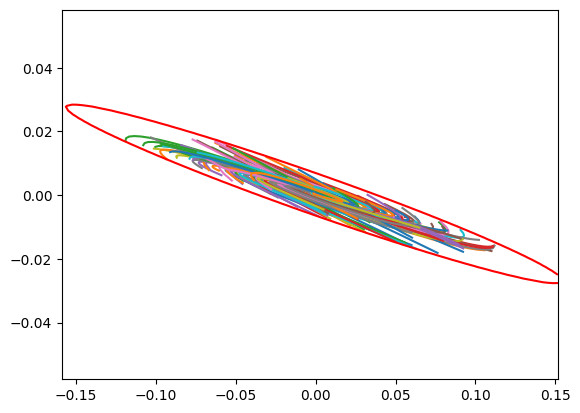

100%|██████████| 310/310 [01:58<00:00,  2.62it/s]


gamma fwd: 0.00078139297
L: 0.6689450740814209
a0: 0.0024951316881924868
Ly/p: 0.00522709
R: 0.000343043589964509


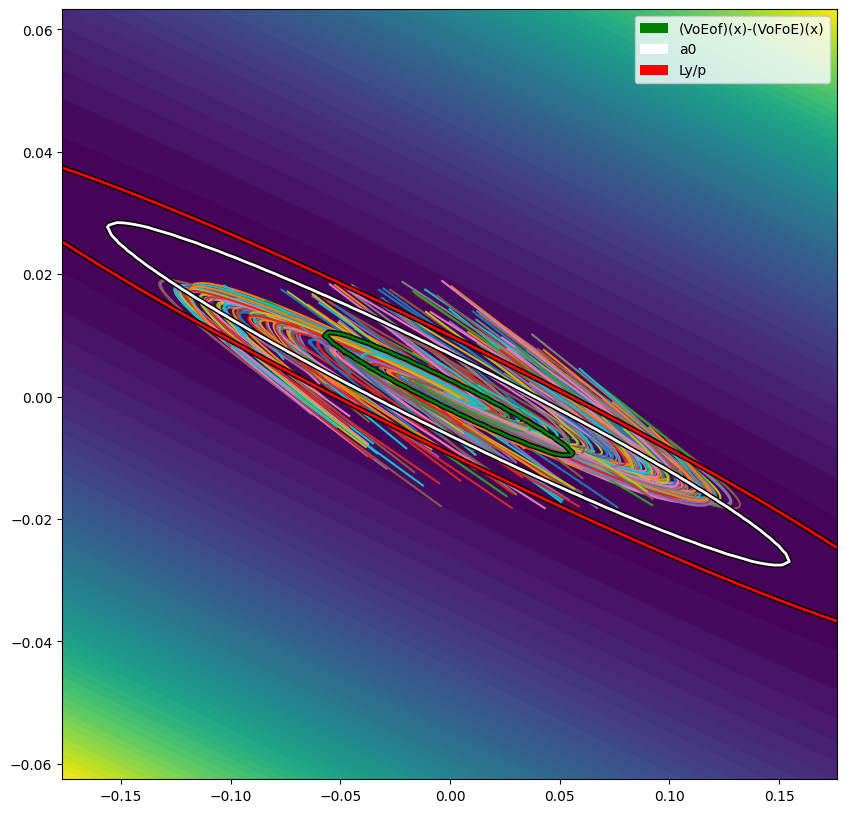

In [9]:
from theorem_tools import compute_preimage, plot_lyapunov_lvlsets

#Dx = compute_preimage(ae, z_data, 0.05, 10, uniform_sampling=True)
Dx = compute_preimage(ae, z_data, 0.05, 7, uniform_sampling=True) #7
print(Dx.shape)
a0 = torch.max(V(ae.encode(torch.tensor(Dx)))).cpu().item()
print(a0)
Dz = z_data
plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0/8, only_rollout=False)
#plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0)

3000


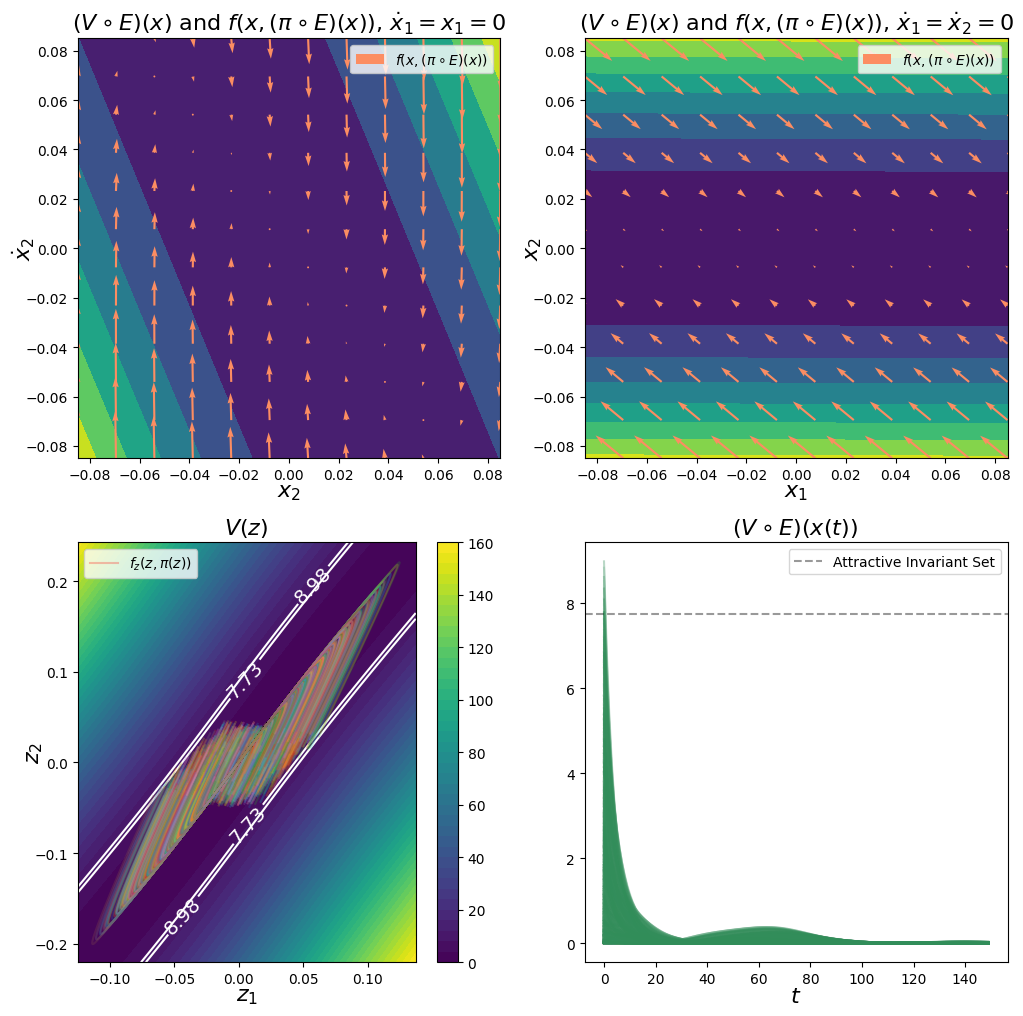

In [28]:
###################
### Make Figure ###
###################


from plotting import plot_lyapunov_slice

lqr = LQR(ae, fdyn)
#plot_lyapunov_slice(V, lqr, ae, (0.5, 0.05), (0.5, 0.05), z_data, z_proj_data)
plot_lyapunov_slice(V, lqr, ae, (rz_init, rz_init), (rz_init, rz_init), z_data, z_proj_data, 7.731, alpha)
#0.001974


In [ ]:
###############################################
### Video: Evolution of Latent Trajectories ###
###############################################


from videos import latent_projections_video
from controls import LQR
lqr = LQR(ae, fdyn)
latent_projections_video(lqr, ae, fdyn, 0.2, T=500, N=9)